# Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
import xgboost as xgb
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

# Reading the data 

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

# Discover Data:

In [3]:
train.shape

(43152, 11)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       43152 non-null  int64  
 1   carat    43152 non-null  float64
 2   cut      43152 non-null  object 
 3   color    43152 non-null  object 
 4   clarity  43152 non-null  object 
 5   depth    43152 non-null  float64
 6   table    43152 non-null  float64
 7   price    43152 non-null  int64  
 8   x        43152 non-null  float64
 9   y        43152 non-null  float64
 10  z        43152 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 3.6+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10788 entries, 0 to 10787
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Id       10788 non-null  int64  
 1   carat    10788 non-null  float64
 2   cut      10788 non-null  object 
 3   color    10788 non-null  object 
 4   clarity  10788 non-null  object 
 5   depth    10788 non-null  float64
 6   table    10788 non-null  float64
 7   x        10788 non-null  float64
 8   y        10788 non-null  float64
 9   z        10788 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 842.9+ KB


In [6]:
train.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.8,57.0,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.9,58.0,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.3,56.0,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.2,56.0,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.0,57.0,2596,5.76,5.72,3.50


In [7]:
train.isnull().sum()

Id         0
carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

In [8]:
train.duplicated().sum()

0

In [9]:
train.describe()

,Id,carat,depth,table,price,x,y,z
count,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000,43152.000000
mean,21576.500000,0.797855,61.747177,57.458347,3929.491912,5.731568,5.735018,3.538568
std,12457.053745,0.473594,1.435454,2.233904,3985.527795,1.121279,1.148809,0.708238
min,1.000000,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,10788.750000,0.400000,61.000000,56.000000,947.750000,4.710000,4.720000,2.910000
50%,21576.500000,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,32364.250000,1.040000,62.500000,59.000000,5312.000000,6.540000,6.540000,4.040000
max,43152.000000,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


# EDA : Exploratory Data Analysis

Explore the distribution of the target variable (price)

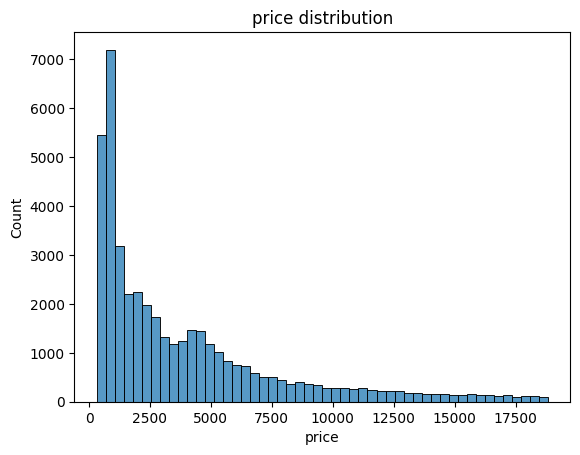

In [10]:
sns.histplot(train["price"], bins=50)
plt.title('price distribution')
plt.show()

Explore the relationship between price and other numerical features

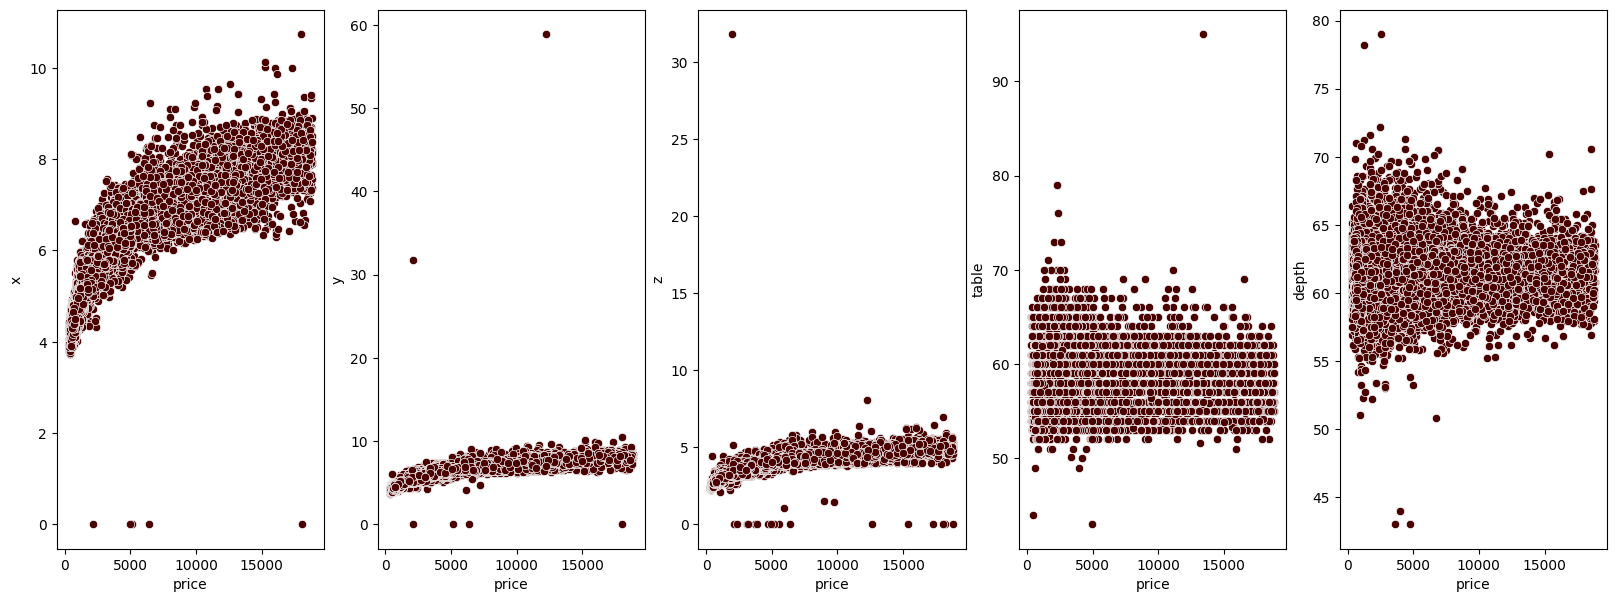

In [11]:
sns.set_palette("afmhot")
cols = ['x','y','z','table','depth']
c = 0
fig, axs = plt.subplots(ncols = len(cols), figsize=(20,7))
for i in cols :
    sns.scatterplot(data = train,x = train['price'],y = train[i], ax = axs[c])
    c+=1

Capping the columns:
- remove all the zeros samples from x, y, z
- x only values that are < 10
- y only values that are < 20
- z only values that are < 10 and > 2.5
- table only values that are < 80 and > 45
- depth only values that are < 75 and > 45

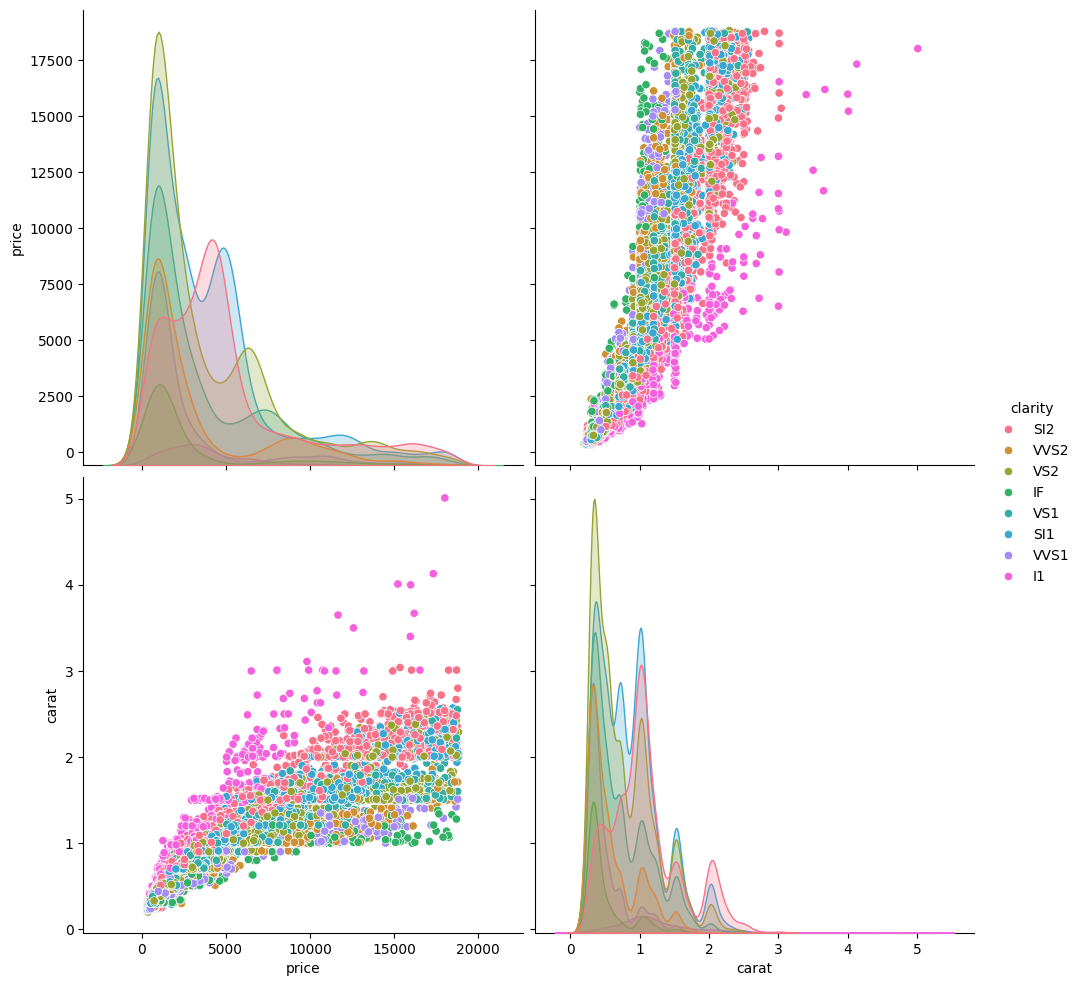

In [12]:
sns.pairplot(train[["price", "carat", "clarity"]], hue = "clarity", height = 5)
plt.show()

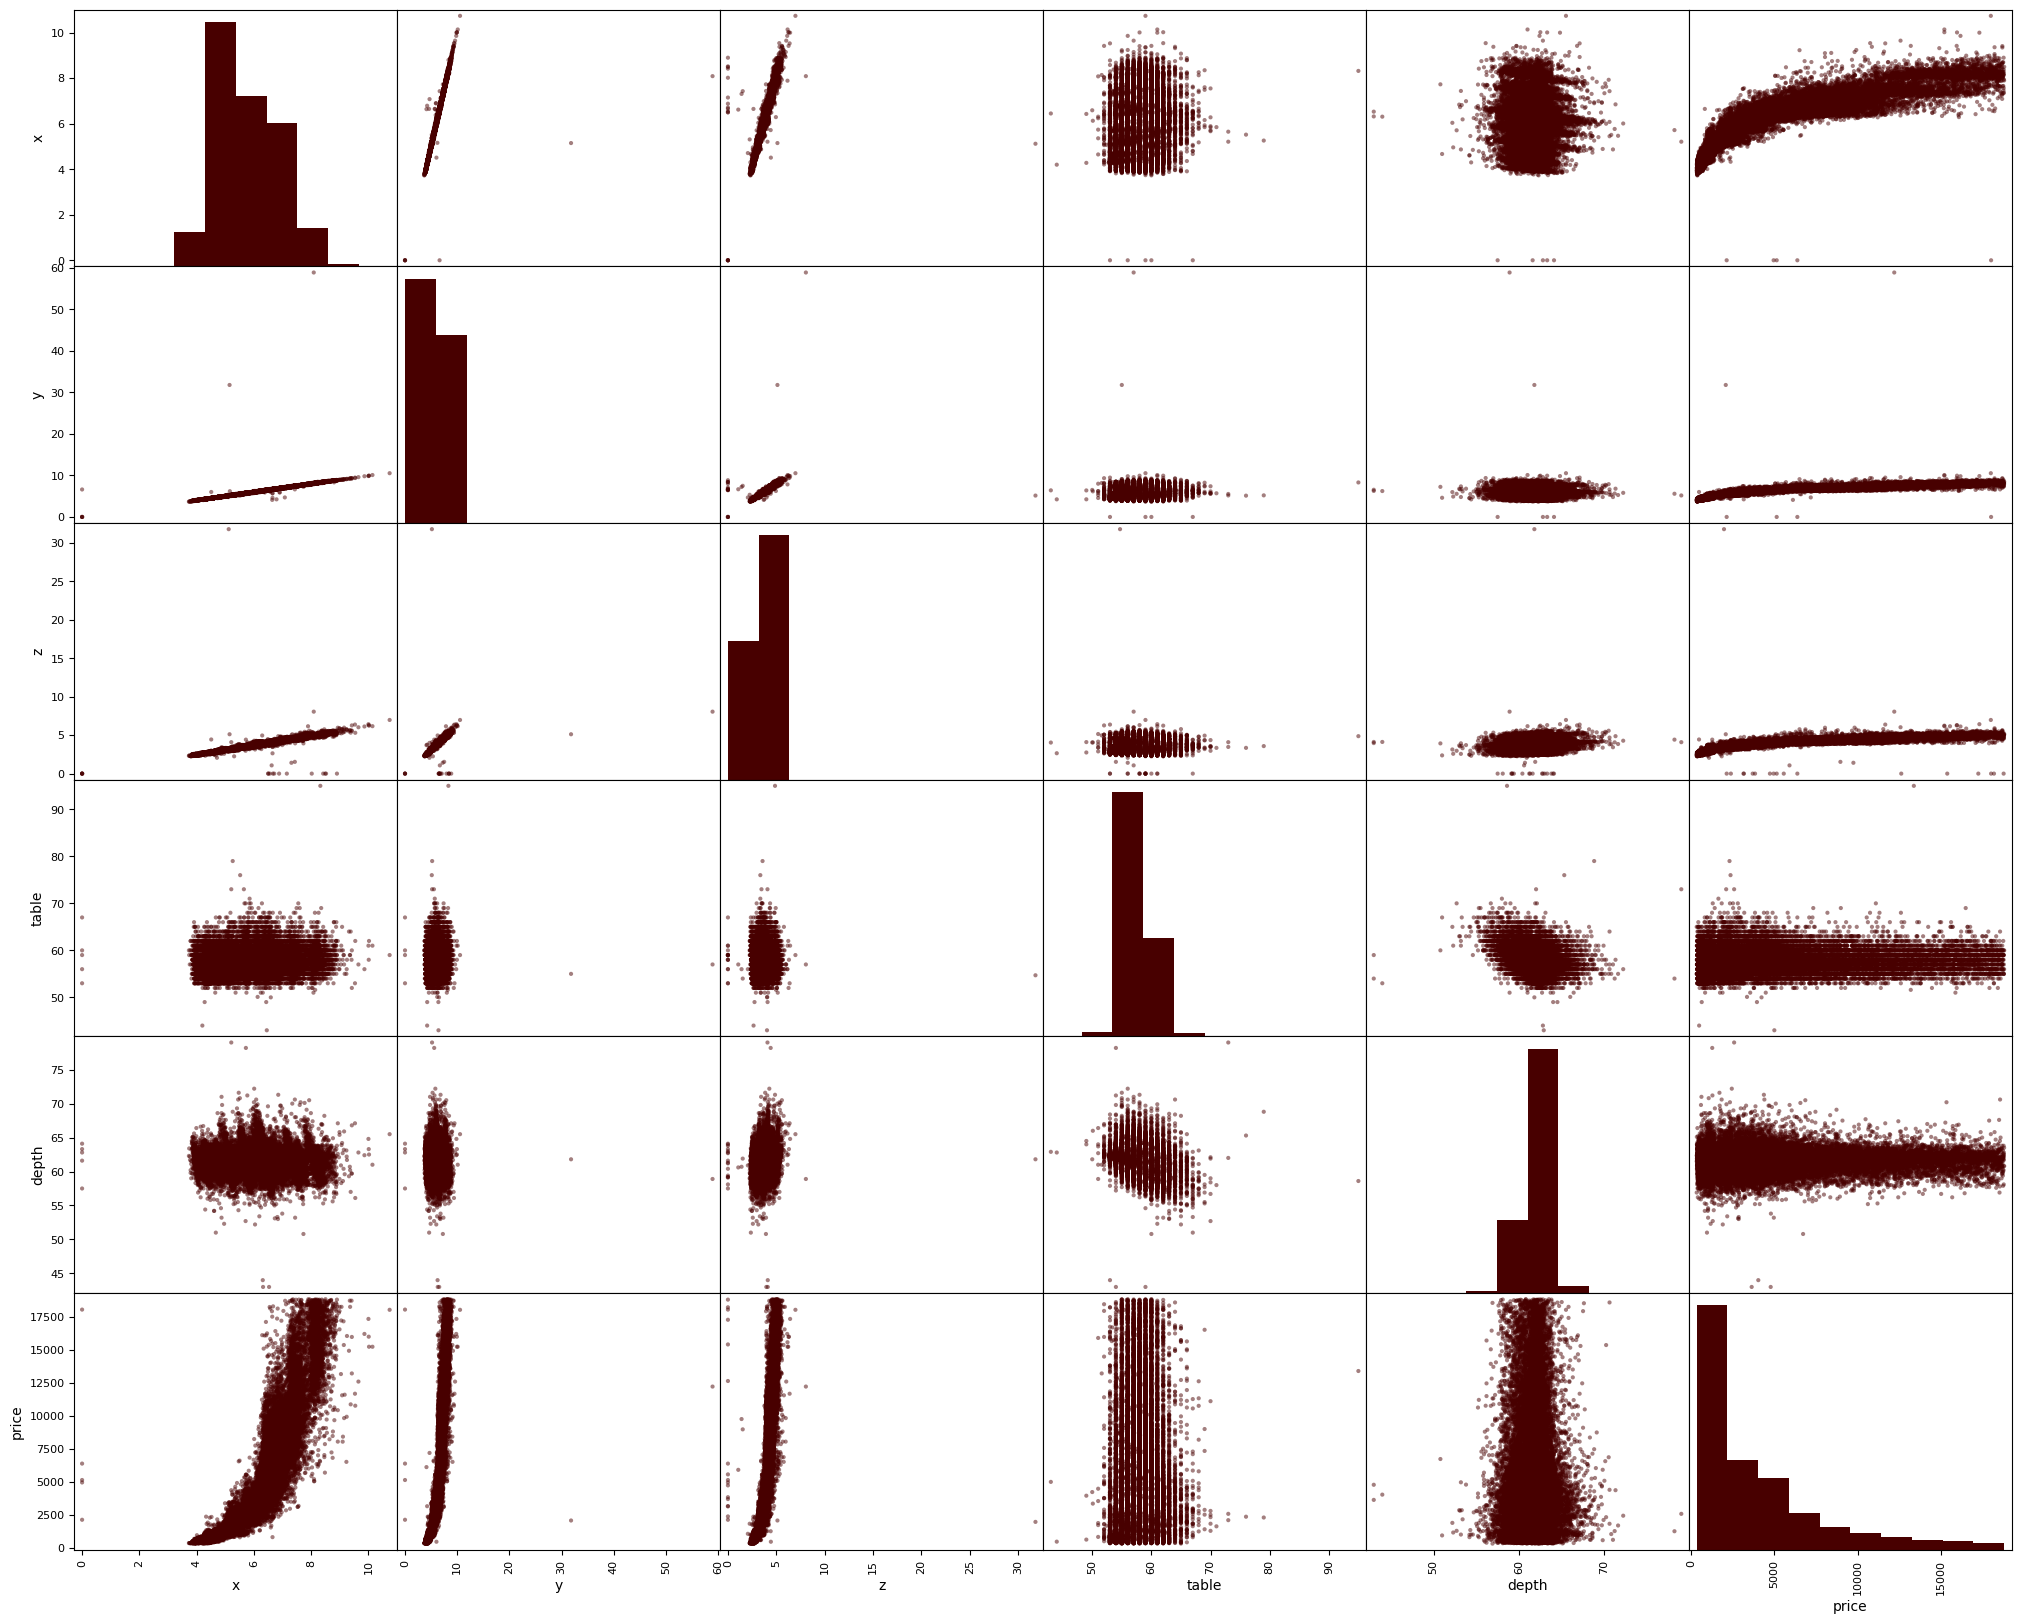

In [13]:
from pandas.plotting import scatter_matrix

attributes = ["x", "y", "z", "table", "depth", "price"]
scatter_matrix(train[attributes], figsize=(25, 20))
plt.show()

These visualizations have been met by our thoughts during correlation. And it's very obvious here that depth and table have very weak correlation with price.

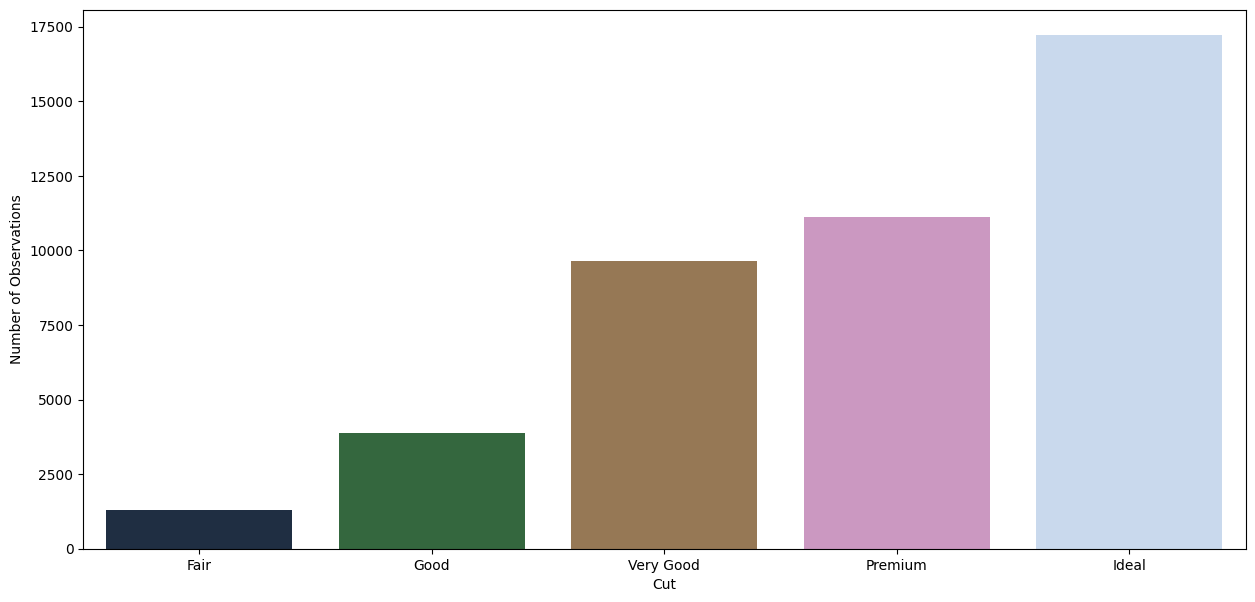

In [14]:
# From Worst to Best (Fair= Worst) ,(Ideal= Best)
plt.figure(figsize= (15, 7))
sns.countplot(x= "cut", data= train, palette= sns.color_palette("cubehelix", 5),
              order=["Fair", "Good", "Very Good", "Premium", "Ideal"])
plt.xlabel("Cut")
plt.ylabel("Number of Observations")
plt.show()

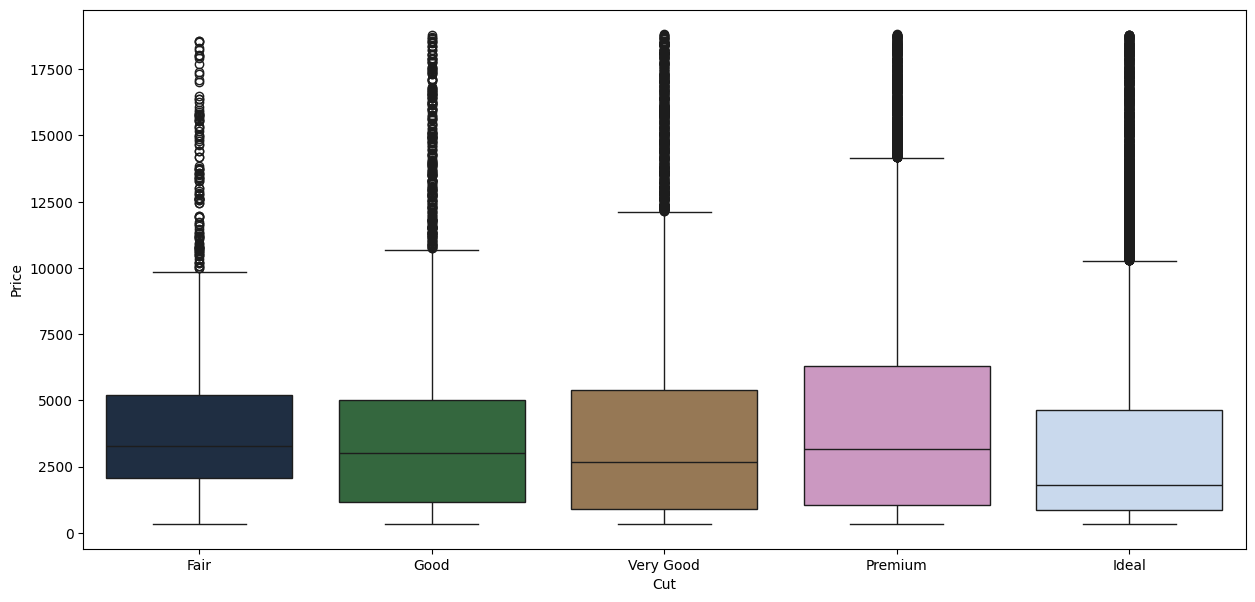

In [15]:
plt.figure(figsize= (15, 7))
sns.boxplot(x= "cut", y= "price", data= train, palette= sns.color_palette("cubehelix", 5),
            order=["Fair", "Good", "Very Good", "Premium", "Ideal"])
plt.xlabel("Cut")
plt.ylabel("Price")
plt.show()

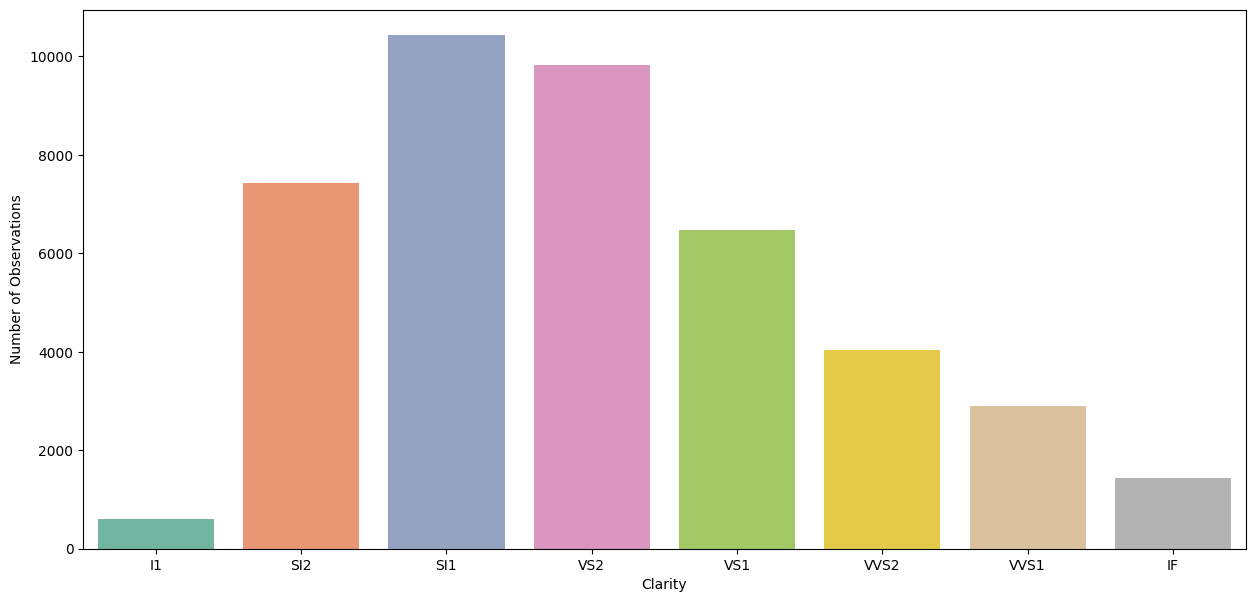

In [16]:
# From Worst to Best (I1= Worst) (IF= Best)
plt.figure(figsize= (15, 7))
sns.countplot(x= "clarity", data= train, order=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"], palette= "Set2")
plt.xlabel("Clarity")
plt.ylabel("Number of Observations")
plt.show()

In [17]:
color_dict = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#5E3434"]

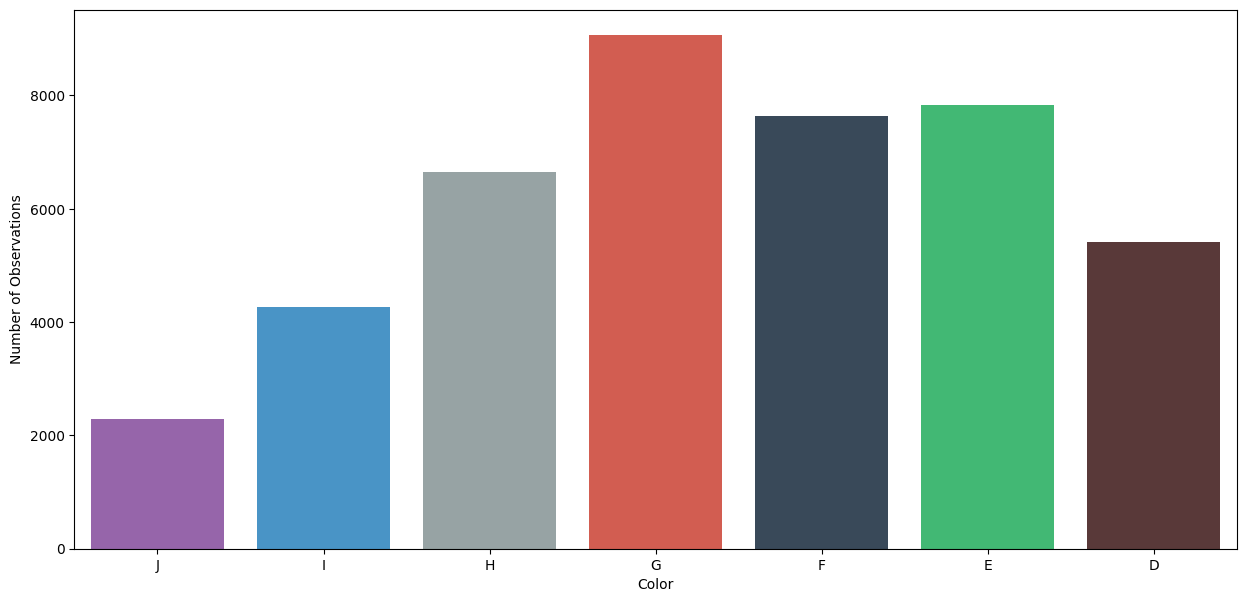

In [18]:
# From Worst to Best (J= Worst) (D= Best)
plt.figure(figsize= (15, 7))
sns.countplot(x= "color", data= train, palette= color_dict, order=["J", "I", "H", "G", "F", "E", "D"])
plt.xlabel("Color")
plt.ylabel("Number of Observations")
plt.show()

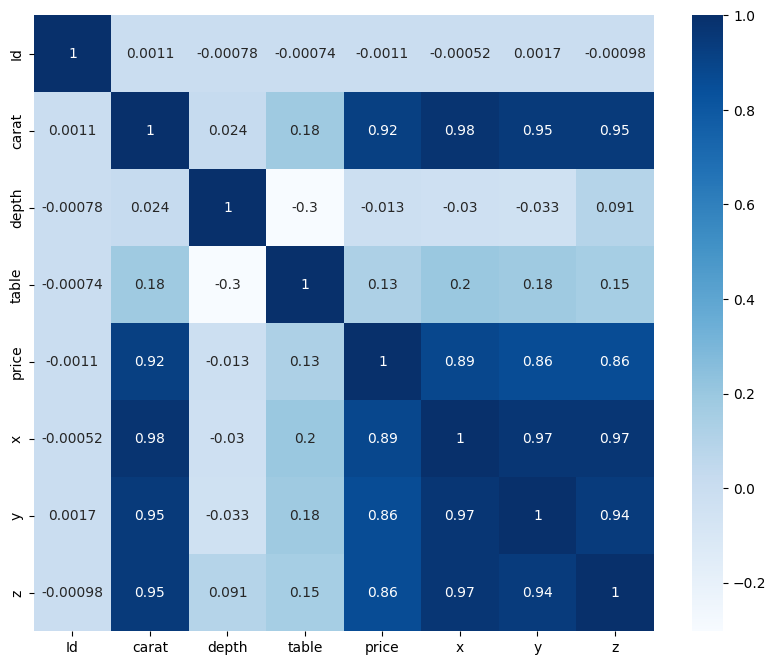

In [19]:
plt.subplots(figsize = (10, 8))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='Blues')
plt.show()

# Clean Data

In [20]:
def number_of_outliers(df, column_name):
    quantiles = df[column_name].quantile([0.25, 0.5, 0.75])
    q1, median, q3 = quantiles[0.25], quantiles[0.5], quantiles[0.75]
    
    IQR = q3 - q1
    
    lower_fence = q1 - 1.5 * IQR
    upper_fence = q3 + 1.5 * IQR

    outliers = len(df[(df[column_name] < lower_fence) | (df[column_name] > upper_fence)])
    
    return outliers

In [21]:
def remove_outliers(df, column_name):
    quantiles = df[column_name].quantile([0.25, 0.5, 0.75])
    q1, median, q3 = quantiles[0.25], quantiles[0.5], quantiles[0.75]
    
    IQR = q3 - q1
    
    lower_fence = q1 - 1.5 * IQR
    upper_fence = q3 + 1.5 * IQR

    filtered_df = df[(df[column_name] >= lower_fence) & (df[column_name] <= upper_fence)]
    
    return filtered_df

remove the data with the min 0 value in either x, y or z features 

In [22]:
print(train.shape)
train = train.drop(train[train["x"] == 0].index)
train = train.drop(train[train["y"] == 0].index)
train = train.drop(train[train["z"] == 0].index)
print(train.shape)

(43152, 11)
(43135, 11)


remove the outliers that we noticed in the plots

In [23]:
train = train[(train['x'] < 30)]
train = train[(train['y'] < 30)]
train = train[(train['z'] < 30) & (train['z'] > 2)]
train = train[(train['table'] < 80) & (train['table'] > 40)]
train = train[(train['depth'] < 75) & (train['depth'] > 45)]

train.shape

(43123, 11)

re calculate the depth column depending on the formula that we know from the docs

In [24]:
train['depth'] = ( (2 * train['z']) / (train['x'] + train['y']) ) * 100
test['depth'] = ( (2 * test['z']) / (test['x'] + test['y']) ) * 100

replace the strings with numbers in the features

In [25]:
print(train["cut"].unique())
print(train["color"].unique())
print(train["clarity"].unique())

['Ideal' 'Premium' 'Very Good' 'Fair' 'Good']
['I' 'G' 'F' 'H' 'D' 'E' 'J']
['SI2' 'VVS2' 'VS2' 'IF' 'VS1' 'SI1' 'VVS1' 'I1']


In [26]:
def encode_labels(df, column_name):
    label_encoder = OrdinalEncoder()
    encoded_values = label_encoder.fit_transform(df[[column_name]])
    df[column_name] = encoded_values
    return df

In [27]:
#train
train = encode_labels(train, 'cut')
train = encode_labels(train, 'color')
train = encode_labels(train, 'clarity')

#test
test = encode_labels(test, 'cut')
test = encode_labels(test, 'color')
test = encode_labels(test, 'clarity')

In [28]:
train = train.drop(["Id"], axis=1)

In [29]:
train.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.06,2.0,5.0,3.0,61.807137,57.0,4270,6.57,6.60,4.07
1,1.51,3.0,3.0,7.0,60.945946,58.0,15164,7.38,7.42,4.51
2,0.32,2.0,2.0,5.0,61.312217,56.0,828,4.43,4.41,2.71
3,0.53,2.0,3.0,5.0,61.287224,56.0,1577,5.19,5.22,3.19
4,0.70,3.0,4.0,7.0,60.975610,57.0,2596,5.76,5.72,3.50


# Add Features

In [30]:
train['volume'] = train['x'] * train['y'] * train['z']
test['volume'] = test['x'] * test['y'] * test['z']

train.drop(columns= ['x', 'y', 'z'], inplace = True)
test.drop(columns= ['x', 'y', 'z'], inplace = True)

In [31]:
train['density'] = train['carat'] / train['volume']
test['density'] = test['carat'] / test['volume']

In [32]:
train['carat_cut'] = train['carat'] * train['cut']
test['carat_cut'] = test['carat'] * test['cut']

In [33]:
train['clarity_color'] = train['clarity'] * train['color']
test['clarity_color'] = test['clarity'] * test['color']

In [34]:
train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

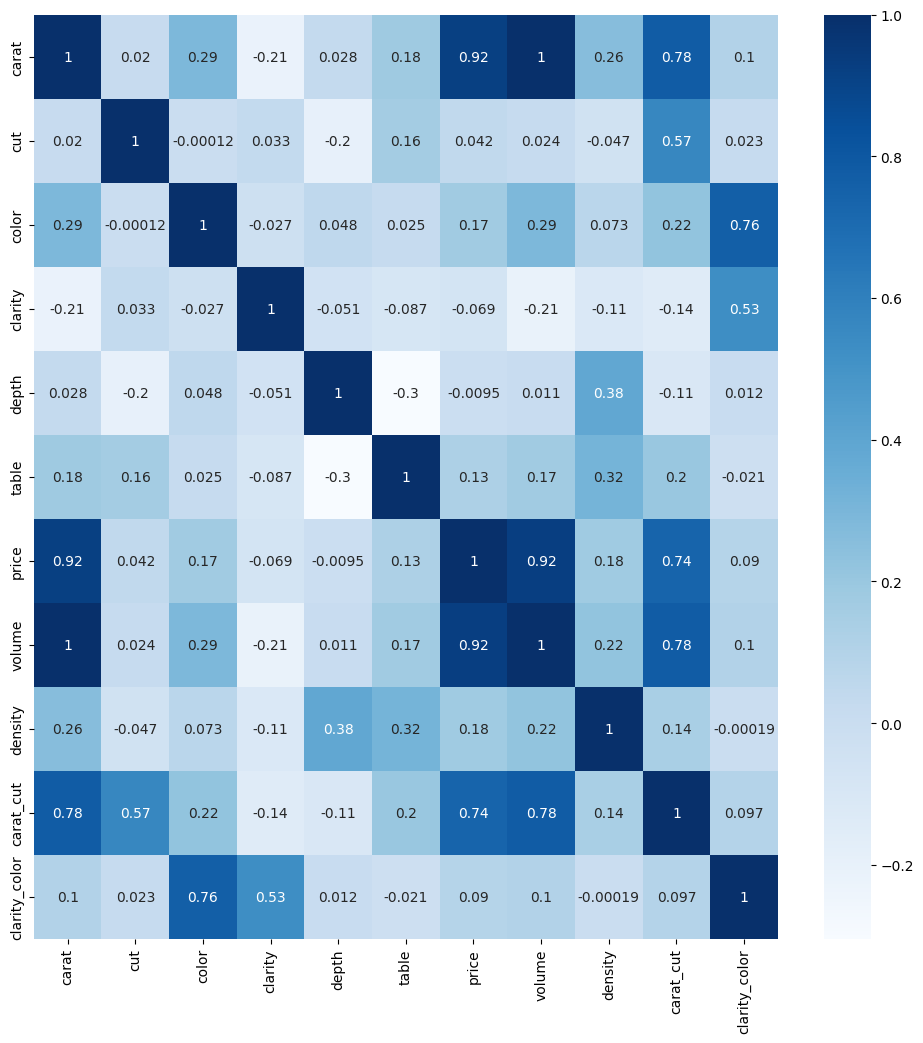

In [35]:
plt.subplots(figsize = (12, 12))
sns.heatmap(train.corr(numeric_only=True), annot=True, cmap='Blues')
plt.show()

# Normalizing Numerical Features

In [36]:
to_scale = ['clarity_color', 'carat_cut', 'density', 'volume', 'carat', 'table', 'depth']

scaler = StandardScaler()

scaler.fit(train[to_scale])
train[to_scale] = scaler.transform(train[to_scale])

scaler.fit(test[to_scale])
test[to_scale] = scaler.transform(test[to_scale])

train = train.fillna(0)

In [37]:
train.head()

,carat,cut,color,clarity,depth,table,price,volume,density,carat_cut,clarity_color
0,0.554677,2.0,5.0,3.0,0.040111,-0.205500,4270,0.611392,-0.876485,0.045440,0.631967
1,1.505492,3.0,3.0,7.0,-0.556946,0.243996,15164,1.534115,-0.091131,1.561643,1.369878
2,-1.008885,2.0,2.0,5.0,-0.303013,-0.654996,828,-1.005935,-0.600374,-0.885671,0.017040
3,-0.565171,2.0,3.0,5.0,-0.320341,-0.654996,1577,-0.567637,0.042927,-0.621437,0.631967
4,-0.205975,3.0,4.0,7.0,-0.536381,-0.205500,2596,-0.189392,-0.410354,0.032858,2.230774


# Model Creating, Fitting and Evaluation :

The metrics we will use are:
- Means Squared Error (MSE): Average squared difference between the estimated values and the actual value
- Root Mean Squared Error (RMSE): The square root of the second sample moment of the differences between predicted values and observed values
- Mean Absolute Error (MAE): Average of all absolute error between paired observations expressing the same phenomenon
- R Squared (R²) The proportion of the variation in the dependent variable (price) that is predictable from the independent variables (features)
- Adjusted R Squared (R²): R² tends to optimistically estimate the fit of the linear regression. It always increases as the number of effects are included in the model. Adjusted R2 attempts to correct for this overestimation. Adjusted R2 might decrease if a specific effect does not improve the model

In [38]:
def get_result(X_test, y_test, pred):
    print("MSE:", metrics.mean_squared_error(y_test, pred))
    print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, pred)))
    print("MAE:", metrics.mean_absolute_error(y_test, pred))
    print("R²:", metrics.r2_score(y_test, pred))
    print("Adjusted R²:", 1 - (1-metrics.r2_score(y_test, pred))*(len(y_test)-1)/(len(y_test) - X_test.shape[1]-1))

prepare data for modeling

In [39]:
X = train.drop(['price'], axis=1)
y = train['price']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)

Linear Regression Model (BaseLine)

In [41]:
regr = LinearRegression()

regr.fit(X_train, y_train)

LinearRegression()

In [42]:
y_pred_ra = regr.predict(X_test)

In [43]:
get_result(X_test, y_test, y_pred_ra)

MSE: 1808431.818133089
RMSE: 1344.779468215175
MAE: 917.6551555587095
R²: 0.8845075594212674
Adjusted R²: 0.8843734841477838


In [44]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state = 42)

tree_reg.fit(X_train,y_train)

DecisionTreeRegressor(random_state=42)

In [45]:
y_pred = tree_reg.predict(X_test)

In [46]:
get_result(X_test, y_test, y_pred)

MSE: 520105.47828341374
RMSE: 721.1833874150276
MAE: 361.84643478260875
R²: 0.9667843429633244
Adjusted R²: 0.9667457828785361


In [47]:
ran_model = RandomForestRegressor()
ran_model.fit(X_train,y_train)

RandomForestRegressor()

In [48]:
y_pred = ran_model.predict(X_test)

In [49]:
get_result(X_test, y_test, y_pred)

MSE: 275767.46951846883
RMSE: 525.135667726416
MAE: 272.6823742971747
R²: 0.98238857679479
Adjusted R²: 0.9823681316784616


In [50]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [51]:
y_pred = xgb_model.predict(X_test)

In [52]:
get_result(X_test, y_test, y_pred)

MSE: 300359.56885010557
RMSE: 548.0506991603108
MAE: 279.25343981579766
R²: 0.9808180439484384
Adjusted R²: 0.9807957755991796


# Fine-Tuning the model's hyperparameters

In [53]:
model = xgb.XGBRegressor()
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1, 0.2],   
    'max_depth': [3, 4, 5, 7, 10, 14],
    'n_estimators': [30, 50, 100]
}

In [54]:
kf = KFold(n_splits=5, shuffle=True, random_state=21)

In [55]:
grid = GridSearchCV(model, param_grid)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 7, 10, 14],
                         'n_estimators': [30, 50, 100]})

In [56]:
best_model = grid.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
y_pred = best_model.predict(X_test)

In [58]:
get_result(X_test, y_test, y_pred)

MSE: 280725.8459990809
RMSE: 529.8356782994903
MAE: 269.6437461786685
R²: 0.9820719184639024
Adjusted R²: 0.9820511057386457


# Submit the result

In [59]:
Id = test['Id']
test = test.drop(["Id"], axis = 1)

In [60]:
pred = xgb_model.predict(test)
data = {'Id': Id, 'price': pred}
sub = pd.DataFrame(data=data)

In [61]:
sub.to_csv('submission_11.csv',index=False)